In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten,Conv2D,MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.metrics import categorical_crossentropy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2
import pickle
import random
import time
import zipfile
from shutil import copyfile
from sklearn.model_selection import train_test_split


In [4]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!ls  /content/drive/MyDrive/'Persian HDR- Javad Pourrafi'/'Train 60000.cdb'

'/content/drive/MyDrive/Persian HDR- Javad Pourrafi/Train 60000.cdb'


In [6]:
# Hoda Dataset Reader


import struct
import numpy as np
import cv2


def __convert_to_one_hot(vector, num_classes):
    result = np.zeros(shape=[len(vector), num_classes])
    result[np.arange(len(vector)), vector] = 1
    return result


def __resize_image(src_image, dst_image_height, dst_image_width):
    src_image_height = src_image.shape[0]
    src_image_width = src_image.shape[1]

    if src_image_height > dst_image_height or src_image_width > dst_image_width:
        height_scale = dst_image_height / src_image_height
        width_scale = dst_image_width / src_image_width
        scale = min(height_scale, width_scale)
        img = cv2.resize(src=src_image, dsize=(0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    else:
        img = src_image

    img_height = img.shape[0]
    img_width = img.shape[1]

    dst_image = np.zeros(shape=[dst_image_height, dst_image_width], dtype=np.uint8)

    y_offset = (dst_image_height - img_height) // 2
    x_offset = (dst_image_width - img_width) // 2

    dst_image[y_offset:y_offset+img_height, x_offset:x_offset+img_width] = img

    return dst_image


def read_hoda_cdb(file_name):
    with open(file_name, 'rb') as binary_file:

        data = binary_file.read()

        offset = 0

        # read private header

        yy = struct.unpack_from('H', data, offset)[0]
        offset += 2

        m = struct.unpack_from('B', data, offset)[0]
        offset += 1

        d = struct.unpack_from('B', data, offset)[0]
        offset += 1

        H = struct.unpack_from('B', data, offset)[0]
        offset += 1

        W = struct.unpack_from('B', data, offset)[0]
        offset += 1

        TotalRec = struct.unpack_from('I', data, offset)[0]
        offset += 4

        LetterCount = struct.unpack_from('128I', data, offset)
        offset += 128 * 4

        imgType = struct.unpack_from('B', data, offset)[0]  # 0: binary, 1: gray
        offset += 1

        Comments = struct.unpack_from('256c', data, offset)
        offset += 256 * 1

        Reserved = struct.unpack_from('245c', data, offset)
        offset += 245 * 1

        if (W > 0) and (H > 0):
            normal = True
        else:
            normal = False

        images = []
        labels = []

        for i in range(TotalRec):

            StartByte = struct.unpack_from('B', data, offset)[0]  # must be 0xff
            offset += 1

            label = struct.unpack_from('B', data, offset)[0]
            offset += 1

            if not normal:
                W = struct.unpack_from('B', data, offset)[0]
                offset += 1

                H = struct.unpack_from('B', data, offset)[0]
                offset += 1

            ByteCount = struct.unpack_from('H', data, offset)[0]
            offset += 2

            image = np.zeros(shape=[H, W], dtype=np.uint8)

            if imgType == 0:
                # Binary
                for y in range(H):
                    bWhite = True
                    counter = 0
                    while counter < W:
                        WBcount = struct.unpack_from('B', data, offset)[0]
                        offset += 1
                        # x = 0
                        # while x < WBcount:
                        #     if bWhite:
                        #         image[y, x + counter] = 0  # Background
                        #     else:
                        #         image[y, x + counter] = 255  # ForeGround
                        #     x += 1
                        if bWhite:
                            image[y, counter:counter + WBcount] = 0  # Background
                        else:
                            image[y, counter:counter + WBcount] = 255  # ForeGround
                        bWhite = not bWhite  # black white black white ...
                        counter += WBcount
            else:
                # GrayScale mode
                data = struct.unpack_from('{}B'.format(W * H), data, offset)
                offset += W * H
                image = np.asarray(data, dtype=np.uint8).reshape([W, H]).T

            images.append(image)
            labels.append(label)

        return images, labels


def read_hoda_dataset(dataset_path, images_height=32, images_width=32, one_hot=False, reshape=True):
    images, labels = read_hoda_cdb(dataset_path)
    assert len(images) == len(labels)

    X = np.zeros(shape=[len(images), images_height, images_width], dtype=np.float32)
    Y = np.zeros(shape=[len(labels)], dtype=int)

    for i in range(len(images)):
        image = images[i]
        # Image resizing.
        image = __resize_image(src_image=image, dst_image_height=images_height, dst_image_width=images_width)
        # Image normalization.
        image = image / 255
        # Image binarization.
        image = np.where(image >= 0.5, 1, 0)
        # Image.
        X[i] = image
        # Label.
        Y[i] = labels[i]

    if one_hot:
        Y = __convert_to_one_hot(Y, 10).astype(dtype=np.float32)
    else:
        Y = Y.astype(dtype=np.float32)

    if reshape:
        X = X.reshape(-1, images_height * images_width)
    else:
        X = X.reshape(-1, images_height, images_width, 1)

    return X, Y

In [7]:
IMG_SIZE=32

In [8]:
X_train, y_train = read_hoda_dataset(dataset_path='/content/drive/MyDrive/Colab Notebooks/Train 60000.cdb',
                                images_height=IMG_SIZE,
                                images_width=IMG_SIZE,
                                one_hot=False,
                                reshape=True)

X_val = X_train[45000:]
y_val = y_train[45000:]
X_train = X_train[:45000]
y_train = y_train[:45000]


In [9]:
X_test, y_test = read_hoda_dataset(dataset_path='/content/drive/MyDrive/Colab Notebooks/Test 20000.cdb',
                                images_height=IMG_SIZE,
                                images_width=IMG_SIZE,
                                one_hot=False,
                                reshape=True)

In [10]:
X_train[0].shape

(1024,)

reshape images => (32,32)

In [11]:
X_train = X_train.reshape(X_train.shape[0], IMG_SIZE, IMG_SIZE)
X_test = X_test.reshape(X_test.shape[0], IMG_SIZE,IMG_SIZE)
X_val=X_val.reshape(X_val.shape[0], IMG_SIZE,IMG_SIZE)

In [12]:
X_train[0].shape

(32, 32)

Plot some images to see samples

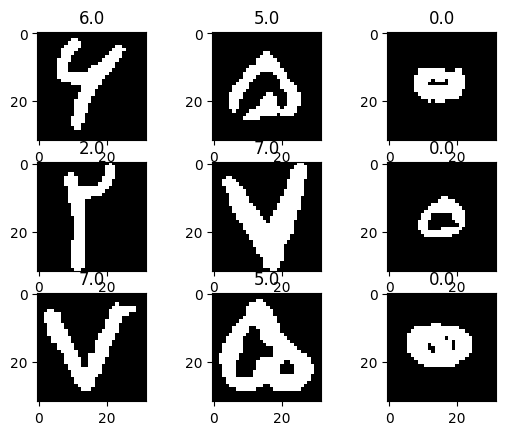

In [18]:
#train samples
for i in range(9):
    plt.subplot(330 + (i+1))
    plt.imshow(X_train[i].squeeze(), cmap=plt.get_cmap('gray'))
    plt.title(y_train[i])

Preprocessing data

In [19]:
def preprocess_data(X_train, y_train, X_test, y_test,X_val,y_val):
  # reshape images to the required size
  X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
  X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
  X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)



  # convert image values from integers to floats
  X_train = X_train.astype('float32')
  X_test = X_test.astype('float32')
  X_val = X_val.astype('float32')



#   # normalization
#   X_train = X_train/255.0
#   X_test_norm = X_test/255.0

  # One-hot encoding label
  y_train = to_categorical(y_train)
  y_test = to_categorical(y_test)
  y_val = to_categorical(y_val)


  return X_train, y_train, X_test, y_test,X_val,y_val

Define Model

In [20]:
def LeNet():
    model = Sequential()

    # Convolutional layer 1
    model.add(Conv2D(64,(5,5),input_shape=(32, 32,1),padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    # Convolutional layer 2
    model.add(Conv2D(32,(3,3),padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    # Dropout layer
    model.add(Dropout(0.25))

    # Flatten layer
    model.add(Flatten()) # 3D feature => 1D feature vector

    # Fully connected layer 1
    model.add(Dense(128, activation='relu'))

    # Fully connected layer 2
    model.add(Dense(64, activation='relu'))


    # The output layer
    model.add(Dense(10, activation = 'softmax'))

#     opt = SGD(learning_rate = lrate, momentum=0.9, decay=decay, nesterov=False)
    opt = Adam()

    model.compile(loss = 'categorical_crossentropy',
                    optimizer = opt,
                    metrics = ['accuracy'])
    return model


In [21]:
LeNet_model = LeNet()
LeNet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        1664      
                                                                 
 activation_2 (Activation)   (None, 32, 32, 64)        0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 32)        18464     
                                                                 
 activation_3 (Activation)   (None, 16, 16, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 8, 8, 32)          0         
 g2D)                                                 

Training model

In [22]:
def summary_history(history):
  plt.figure(figsize=(12,6))
  plt.subplot(1,2,1)
  plt.plot(history.history['accuracy'], label='Train Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.legend()
  plt.xlabel('Number of epochs', fontsize=14)
  plt.ylabel('Accuracy', fontsize=14)
  plt.subplot(1,2,2)
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.legend()
  plt.xlabel('Number of epochs', fontsize=15)
  plt.ylabel('Loss', fontsize=15)
  plt.show()

def train_model(model, X_train, y_train, X_test, y_test,X_val,y_val, epochs = 5, batch_size = 128):
  # Rescaling all training and testing data
  X_train, y_train, X_test, y_test,X_val,y_val= preprocess_data(X_train, y_train, X_test, y_test,X_val,y_val)
  # Fitting the model on the training set
  history = model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size,
                      steps_per_epoch = X_train.shape[0]//batch_size,
                      validation_data = (X_val,y_val),
                      validation_steps = X_val.shape[0]//batch_size)
  # evaluating the model
  _, acc = model.evaluate(X_test, y_test, verbose = 1)
  print('%.3f' % (acc * 100.0))
  summary_history(history)

Epoch 1/5
351/351 [==============================] - 9s 11ms/step - loss: 0.1603 - accuracy: 0.9535 - val_loss: 0.0426 - val_accuracy: 0.9870
Epoch 2/5
351/351 [==============================] - 3s 8ms/step - loss: 0.0382 - accuracy: 0.9880 - val_loss: 0.0399 - val_accuracy: 0.9878
Epoch 3/5
351/351 [==============================] - 3s 8ms/step - loss: 0.0216 - accuracy: 0.9931 - val_loss: 0.0192 - val_accuracy: 0.9947
Epoch 4/5
351/351 [==============================] - 3s 9ms/step - loss: 0.0192 - accuracy: 0.9940 - val_loss: 0.0252 - val_accuracy: 0.9927
Epoch 5/5
625/625 [==============================] - 2s 3ms/step - loss: 0.0326 - accuracy: 0.9908
99.075


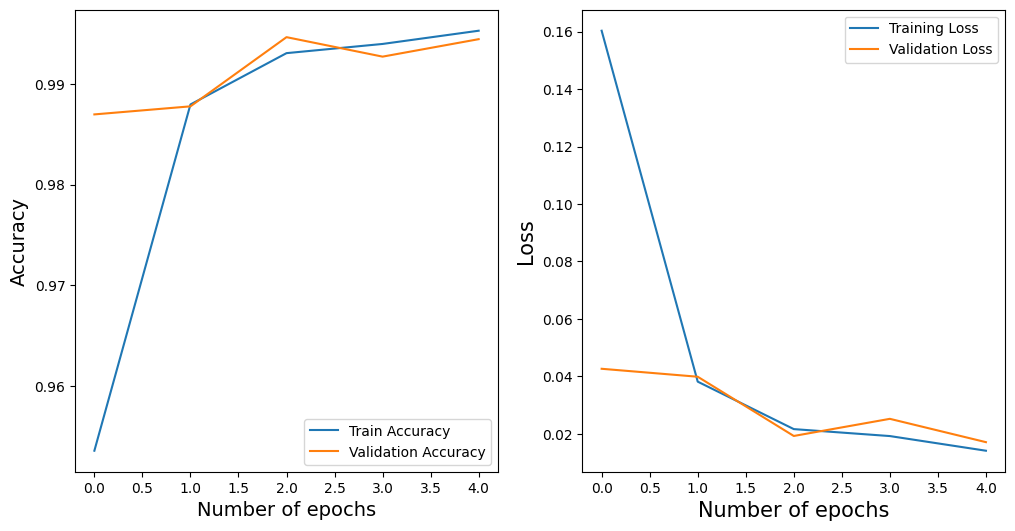

In [23]:
train_model(LeNet_model, X_train, y_train, X_test, y_test,X_val,y_val)

Testing model with data from real world

In [24]:
!ls  /content/drive/MyDrive/'Persian HDR- Javad Pourrafi'/'Test pics'/'2.jpg'
!ls  /content/drive/MyDrive/'Persian HDR- Javad Pourrafi'/'Test pics'/'3.jpg'
!ls  /content/drive/MyDrive/'Persian HDR- Javad Pourrafi'/'Test pics'/'4.jpg'
!ls  /content/drive/MyDrive/'Persian HDR- Javad Pourrafi'/'Test pics'/'5.jpg'
!ls  /content/drive/MyDrive/'Persian HDR- Javad Pourrafi'/'Test pics'/'8.jpg'
!ls  /content/drive/MyDrive/'Persian HDR- Javad Pourrafi'/'Test pics'/'9.jpg'

'/content/drive/MyDrive/Persian HDR- Javad Pourrafi/Test pics/2.jpg'
'/content/drive/MyDrive/Persian HDR- Javad Pourrafi/Test pics/3.jpg'
'/content/drive/MyDrive/Persian HDR- Javad Pourrafi/Test pics/4.jpg'
'/content/drive/MyDrive/Persian HDR- Javad Pourrafi/Test pics/5.jpg'
'/content/drive/MyDrive/Persian HDR- Javad Pourrafi/Test pics/8.jpg'
'/content/drive/MyDrive/Persian HDR- Javad Pourrafi/Test pics/9.jpg'


Loading some picture wich is my handwritten text

In [25]:
import tensorflow as tf

# Load the image\
path2 = '/content/drive/MyDrive/Persian HDR- Javad Pourrafi/Test pics/2.jpg'
path3 = '/content/drive/MyDrive/Persian HDR- Javad Pourrafi/Test pics/3.jpg'
path4 = '/content/drive/MyDrive/Persian HDR- Javad Pourrafi/Test pics/4.jpg'
path5 = '/content/drive/MyDrive/Persian HDR- Javad Pourrafi/Test pics/5.jpg'
path8 = '/content/drive/MyDrive/Persian HDR- Javad Pourrafi/Test pics/8.jpg'
path9 = '/content/drive/MyDrive/Persian HDR- Javad Pourrafi/Test pics/9.jpg'

Pre-Process of real world data

In [26]:
def preprocess(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=1)

  img = tf.image.resize(img, (32, 32))

  img = tf.where(img>127, tf.zeros_like(img), tf.ones_like(img))

  img = tf.expand_dims(img, axis=0)
  return img

In [27]:
def realpicShow(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=1)
  return img

Tests

Number 2

real picture is


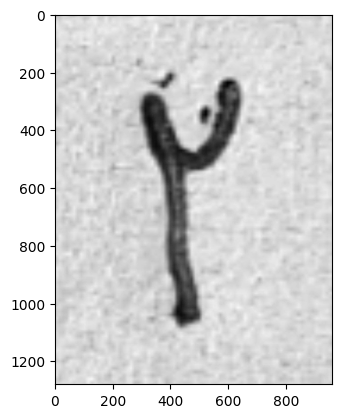

In [28]:
print("real picture is")
x=realpicShow(path2)
plt.imshow(tf.squeeze(tf.math.round(x)), cmap='gray')

1/1 [==============================] - 0s 208ms/step
[[8.4957904e-08 8.9294399e-06 9.9370170e-01 5.6358669e-03 4.1621621e-04
  3.4326638e-07 1.5222082e-04 1.5687894e-05 1.3407073e-06 6.7655361e-05]]
output of model is 2


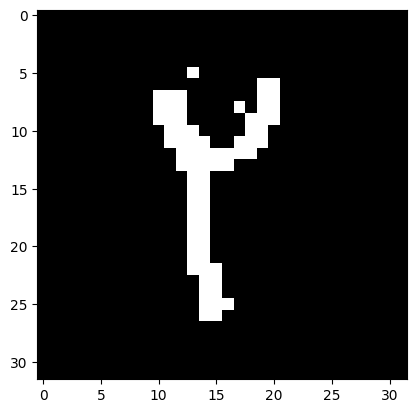

In [29]:
img = preprocess(path2)
plt.imshow(tf.squeeze(tf.math.round(img)), cmap='gray')
predictions = LeNet_model.predict([img])
output=np.argmax(predictions)
print(predictions)
print('output of model is',output)

Number 3

real picture is


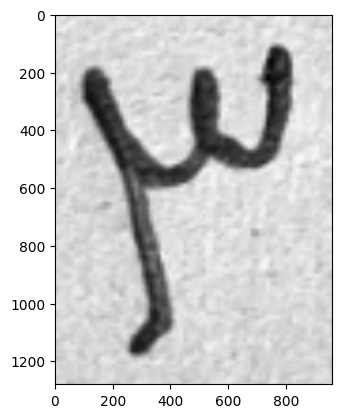

In [30]:
print("real picture is")
x=realpicShow(path3)
plt.imshow(tf.squeeze(tf.math.round(x)), cmap='gray')

1/1 [==============================] - 0s 31ms/step
[[4.5921452e-12 3.1979225e-10 6.6545351e-07 9.9998891e-01 8.5676729e-06
  5.4726021e-13 1.7585683e-06 5.7837277e-09 9.1817949e-11 3.1188909e-09]]
output of model is 3


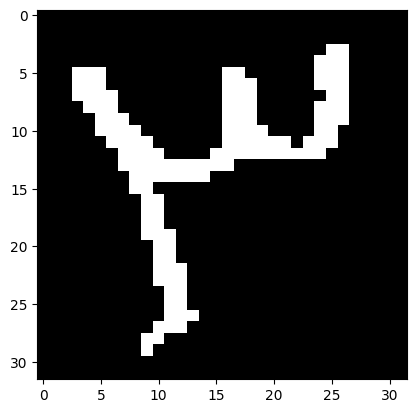

In [31]:
img = preprocess(path3)
plt.imshow(tf.squeeze(tf.math.round(img)), cmap='gray')
predictions = LeNet_model.predict([img])
output=np.argmax(predictions)
print(predictions)
print('output of model is',output)

Number 4

real picture is


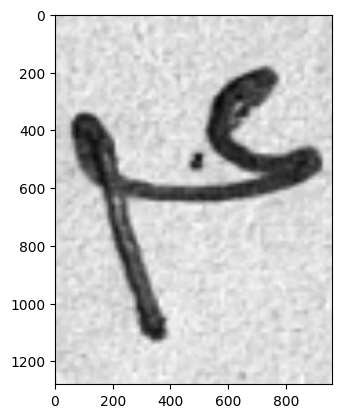

In [32]:
print("real picture is")
x=realpicShow(path4)
plt.imshow(tf.squeeze(tf.math.round(x)), cmap='gray')

1/1 [==============================] - 0s 80ms/step
[[5.6677891e-07 5.4239678e-08 1.2198930e-06 9.0213274e-05 9.9990225e-01
  5.1102180e-08 2.4934945e-06 3.1779216e-06 9.6551966e-10 1.4314279e-08]]
output of model is 4


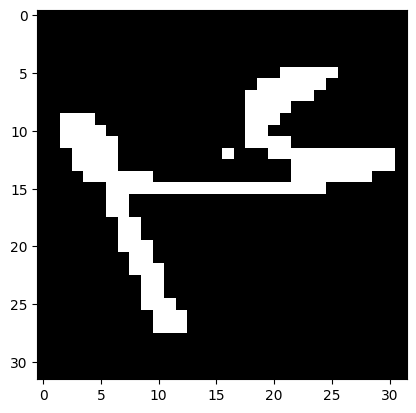

In [33]:
img = preprocess(path4)
plt.imshow(tf.squeeze(tf.math.round(img)), cmap='gray')
predictions = LeNet_model.predict([img])
output=np.argmax(predictions)
print(predictions)
print('output of model is',output)

Number 5

real picture is


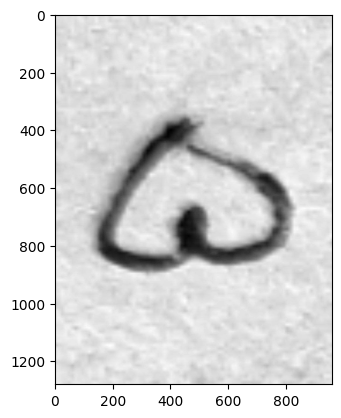

In [34]:
print("real picture is")
x=realpicShow(path5)
plt.imshow(tf.squeeze(tf.math.round(x)), cmap='gray')

1/1 [==============================] - 0s 35ms/step
[[8.6413511e-06 2.6509580e-08 8.8670141e-11 8.4601888e-11 2.2706181e-06
  9.9997056e-01 4.7464828e-09 2.7678453e-08 1.8483979e-05 2.7157590e-09]]
output of model is 5


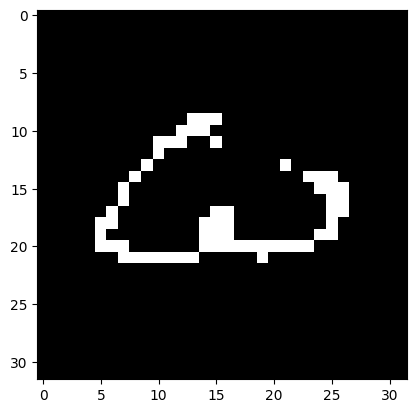

In [35]:
img = preprocess(path5)
plt.imshow(tf.squeeze(tf.math.round(img)), cmap='gray')
predictions = LeNet_model.predict([img])
output=np.argmax(predictions)
print(predictions)
print('output of model is',output)

Number 8

real picture is


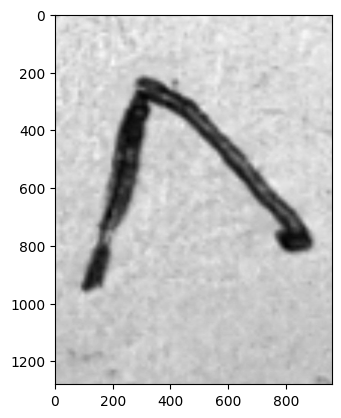

In [36]:
print("real picture is")
x=realpicShow(path8)
plt.imshow(tf.squeeze(tf.math.round(x)), cmap='gray')

1/1 [==============================] - 0s 86ms/step
[[5.3786533e-08 2.1795045e-10 2.0601960e-12 1.7179938e-11 2.6139471e-06
  3.9102115e-02 6.1015001e-08 4.8290802e-11 9.6089518e-01 5.0529836e-10]]
output of model is 8


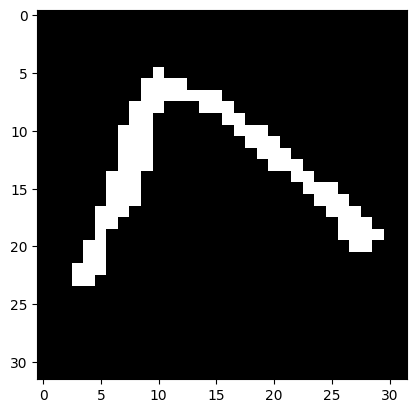

In [37]:
img = preprocess(path8)
plt.imshow(tf.squeeze(tf.math.round(img)), cmap='gray')
predictions = LeNet_model.predict([img])
output=np.argmax(predictions)
print(predictions)
print('output of model is',output)

Number 9

real picture is


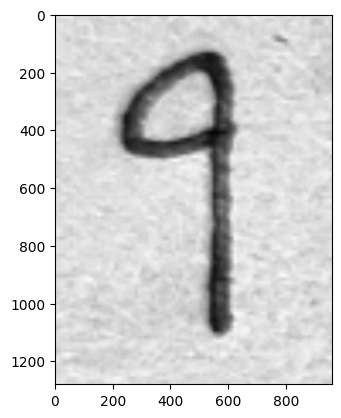

In [38]:
print("real picture is")
x=realpicShow(path9)
plt.imshow(tf.squeeze(tf.math.round(x)), cmap='gray')

1/1 [==============================] - 0s 88ms/step
[[6.3085731e-11 1.0160337e-09 1.5292484e-07 6.1202110e-10 3.3533559e-10
  4.9723635e-11 1.5117045e-05 3.5979053e-11 1.6502971e-08 9.9998474e-01]]
output of model is 9


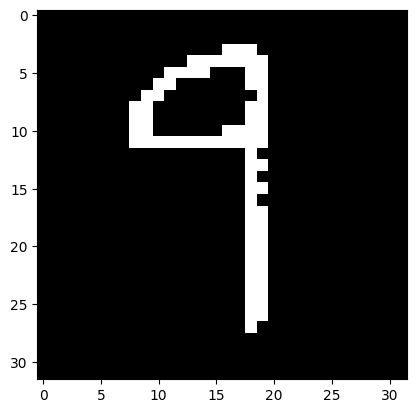

In [39]:
img = preprocess(path9)
plt.imshow(tf.squeeze(tf.math.round(img)), cmap='gray')
predictions = LeNet_model.predict([img])
output=np.argmax(predictions)
print(predictions)
print('output of model is',output)